<a href="https://colab.research.google.com/github/elliothebert/code/blob/main/portfolio_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install quandl
import quandl

In [ ]:
quandl.ApiConfig.api_key = "ywek9zq_ayRPip4z15N4"

In [ ]:
#Google - Stock Price
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2018-01-01')
data = quandl.get('WIKI/GOOGL', start_date = start, end_date=end)
data.head(10)

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2012-01-03,652.94,668.15,652.370,665.41,7345600.0,0.0,1.0,327.480902,335.109451,327.195020,333.735209,7345600.0
2012-01-04,665.03,670.25,660.620,668.28,5722200.0,0.0,1.0,333.544620,336.162702,331.332793,335.174652,5722200.0
2012-01-05,662.13,663.97,656.230,659.01,6559200.0,0.0,1.0,332.090130,333.012979,329.130996,330.525300,6559200.0
2012-01-06,659.15,660.00,649.790,650.02,5380400.0,0.0,1.0,330.595517,331.021833,325.901025,326.016381,5380400.0
2012-01-09,646.50,647.00,621.230,622.46,11633500.0,0.0,1.0,324.250932,324.501706,311.576808,312.193712,11633500.0
2012-01-10,629.75,633.80,616.910,623.14,8782400.0,0.0,1.0,315.849999,317.881269,309.410119,312.534765,8782400.0
2012-01-11,623.50,629.39,621.124,625.96,4795200.0,0.0,1.0,312.715322,315.669441,311.523644,313.949131,4795200.0
2012-01-12,631.22,632.89,626.500,629.64,3746600.0,0.0,1.0,316.587275,317.424860,314.219967,315.794828,3746600.0
2012-01-13,626.26,626.95,621.060,624.99,4609900.0,0.0,1.0,314.099595,314.445664,311.491545,313.462629,4609900.0


In [ ]:

df = data['Close']
df.head(10)

Date
2012-01-03    665.41
2012-01-04    668.28
2012-01-05    659.01
2012-01-06    650.02
2012-01-09    622.46
2012-01-10    623.14
2012-01-11    625.96
2012-01-12    629.64
2012-01-13    624.99
2012-01-17    628.58
Name: Close, dtype: float64

In [ ]:
# Tesla - Closing Stock Price
data2 = quandl.get('WIKI/TSLA', start_date = start, end_date=end)
df2=data2['Close']
df2.head(10)

Date
2012-01-03    28.08
2012-01-04    27.71
2012-01-05    27.12
2012-01-06    26.91
2012-01-09    27.25
2012-01-10    27.62
2012-01-11    28.23
2012-01-12    28.25
2012-01-13    22.79
2012-01-17    26.60
Name: Close, dtype: float64

In [ ]:
# Morgan Stanley - Closing Stock Price
data3 = quandl.get('WIKI/MS', start_date = start, end_date=end)
df3=data3['Close']
df3.head(10)

Date
2012-01-03    16.08
2012-01-04    15.94
2012-01-05    16.28
2012-01-06    15.90
2012-01-09    16.20
2012-01-10    16.89
2012-01-11    17.10
2012-01-12    17.17
2012-01-13    16.63
2012-01-17    16.25
Name: Close, dtype: float64

In [ ]:
result = pd.concat([df, df2, df3], axis=1, join="inner")
result.columns =['GOOGL', 'TSLA', 'MS']
result

,GOOGL,TSLA,MS
Date,,,
2012-01-03,665.41,28.08,16.08
2012-01-04,668.28,27.71,15.94
2012-01-05,659.01,27.12,16.28
2012-01-06,650.02,26.91,15.90
2012-01-09,622.46,27.25,16.20
...,...,...,...
2017-12-22,1068.86,325.20,52.72
2017-12-26,1065.85,317.29,52.47
2017-12-27,1060.20,311.64,52.57


In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1508 entries, 2012-01-03 to 2017-12-29
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GOOGL   1508 non-null   float64
 1   TSLA    1508 non-null   float64
 2   MS      1508 non-null   float64
dtypes: float64(3)
memory usage: 47.1 KB


In [ ]:
Maintenant que nous avons les données pour les 3 entreprises de notre portefeuille, nous allons pouvoir commencer l'analyse. 
Comme dans beaucoup de modeles financiers (Black-Scholes par exemple), il est preferable de calculer le log return sur une longue periode au lieu du rendement moyen.
Concernant l'allocation des actions dans le portefeuille, nous allons generer cela de maniere aleatoire et ensuite nous effectuerons une simulation Monte Carlo afin d'obtenir la repartition qui nous permettra d'avoir le meilleur ratio rendement/risque (Sharpe Ratio) ou bien le minimum de volatilite.
Dans ce projet, nous considererons que le risk free rate est egal à 1%

In [ ]:
log_return = np.log(1 + result.pct_change())

log_return


,GOOGL,TSLA,MS
Date,,,
2012-01-03,NaN,NaN,NaN
2012-01-04,0.004304,-0.013264,-0.008745
2012-01-05,-0.013969,-0.021522,0.021106
2012-01-06,-0.013736,-0.007773,-0.023618
2012-01-09,-0.043324,0.012556,0.018692
...,...,...,...
2017-12-22,-0.001860,-0.019670,-0.003030
2017-12-26,-0.002820,-0.024624,-0.004753
2017-12-27,-0.005315,-0.017968,0.001904


In [ ]:
number_stocks = 3

random_weights = np.array(np.random.random(number_stocks))

sum_weights = np.sum(random_weights)

rebalance = random_weights / sum_weights 

rebalance

array([0.34693935, 0.44087486, 0.21218579])

In [ ]:
daily_std = log_return.std()
daily_std

GOOGL    0.022427
TSLA     0.030312
MS       0.018026
dtype: float64

In [ ]:
annual_volatility = log_return.std()*252**.5
annual_volatility

GOOGL    0.356010
TSLA     0.481182
MS       0.286154
dtype: float64

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


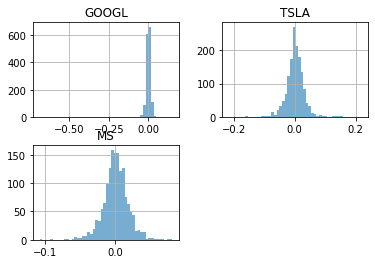

In [ ]:
str_vol = str(round(annual_volatility, 4)*100)

fig, ax = plt.subplots()
log_return.hist(ax=ax, bins=50, alpha=0.6)
#ax.set_xlabel(“Log return”)
#ax.set_ylabel(“Freq of log return”)
#ax.set_title(“AAPL volatility: ” + str_vol + “%”)
plt.show()

In [ ]:
expected_return = np.sum(log_return.mean() * rebalance * 252)
expected_return

0.24598063604209186

In [ ]:
rf_rate = 0.01
sharpe_ratio = (expected_return - rf_rate)/annual_volatility
sharpe_ratio

GOOGL    0.662848
TSLA     0.490419
MS       0.824663
dtype: float64

In [ ]:
#Monte Carlo
num_simulations = 1000

all_weights = np.zeros((num_simulations, number_stocks))

return_array = np.zeros(num_simulations)

volatility_array = np.zeros(num_simulations)

sharpe_ratio_array = np.zeros(num_simulations)

for x in range(num_simulations):

  weights = np.array(np.random.random(number_stocks))
  weights = weights / np.sum(weights)

  all_weights[x, :] = weights

  return_array[x] = np.sum(log_return.mean() * weights * 252)

  volatility_array[x] = np.sqrt(np.dot(log_return.cov() * 252, weights))

  sharpe_ratio_array[x] = (return_array - rf_rate) / volatility_array[x]



simulation = [return_array, volatility_array, sharpe_ratio_array, all_weights]

df = pd.DataFrame(data=simulation).T

df.columns = ["Return", "Volatility", "Sharpe Ratio", "Weights"]


print('')
print('=' * 80)
print('MONTE CARLO SIMULATIONS:')
print('=' * 80)
print(df.head())
print('=' * 80)




ValueError: ignored

# Now we'll take the simulation with the best risk/reward

max_sharpe_ratio = df.loc[df['Sharpe Ratio'].idxmax()]

#Now we'll take the simulation with the minimum of volatility (more conservative)

min_volatility = df.loc[df['Volatility'].idxmin()]

print('')
print('=' * 80)
print('MAX SHARPE RATIO:')
print('-' * 80)
print(max_sharpe_ratio)
print('-' * 80)

print('')
print('=' * 80)
print('MIN VOLATILITY:')
print('-' * 80)
print(min_volatility)
print('-' * 80)
